In [1]:
with open("vacancies.txt", mode='r', encoding='utf-8') as vf:
    vacancies = vf.readlines()

with open("labels.txt", mode='r', encoding='utf-8') as lf:
    labels = lf.readlines()

In [2]:
import numpy as np
from numpy import newaxis
import pandas as pd

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from stop_words import get_stop_words

from collections import Counter
import matplotlib.pyplot as plt

import sklearn
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import torch

train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    torch.cuda.current_device()

import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F


C:\Users\3naza\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\3naza\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
tokenizer = RegexpTokenizer(r'\w+')
v_tokenized = [tokenizer.tokenize(vacancy.lower()) for vacancy in vacancies]
v_tokenized[0][:10]

['computer',
 'systems',
 'sql',
 'trainee',
 'analyst',
 'company',
 'at',
 'consulting',
 'region',
 'kiev']

In [5]:
word_lem = WordNetLemmatizer()
v_lemmatized = [[word_lem.lemmatize(word) for word in vacancy] for vacancy in v_tokenized]
v_lemmatized[0][:10]

['computer',
 'system',
 'sql',
 'trainee',
 'analyst',
 'company',
 'at',
 'consulting',
 'region',
 'kiev']

In [6]:
eng_stop_words = get_stop_words('english')
v_cleared = [[word for word in vacancy if word not in eng_stop_words] for vacancy in v_lemmatized]
v_cleared[0][:10]

['computer',
 'system',
 'sql',
 'trainee',
 'analyst',
 'company',
 'consulting',
 'region',
 'kiev',
 'company']

In [7]:
words = ' '.join([' '.join(vacancy) for vacancy in v_cleared]).split()
words[:10]

['computer',
 'system',
 'sql',
 'trainee',
 'analyst',
 'company',
 'consulting',
 'region',
 'kiev',
 'company']

In [8]:
counts_words = Counter(words)
vocab = sorted(counts_words, key=counts_words.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

vacancies_ints = []
for vacancy in v_cleared:
    vacancies_ints.append([vocab_to_int[word] for word in vacancy])

In [9]:
print('Unique words: ', len((vocab_to_int)))
print()

print('Tokenized vacancy: \n', vacancies_ints[:2])

Unique words:  14397

Tokenized vacancy: 
 [[216, 13, 75, 1501, 265, 4, 256, 39, 79, 4, 141, 256, 22, 567, 277, 444, 64, 11, 320, 96, 145, 19, 15, 46, 50, 40, 256, 1314, 99, 113, 60, 117, 16, 256, 510, 442, 174, 17, 22, 31, 175, 4, 680, 301, 1665, 178, 3353, 1400, 1143, 119, 2192, 3226, 382, 385, 239, 141, 456, 2424, 1113, 2652, 2017, 457, 4014, 3504, 7227, 5715, 547, 779, 873, 162, 22, 87, 197, 174, 13, 85, 1164, 20, 256, 830, 7, 2, 555, 18, 257, 1049, 237, 842, 47, 6, 964, 190, 147, 294, 12, 41, 1586, 351, 133, 5, 75, 41, 148, 53, 378, 8333, 225, 142, 393, 305, 270, 49, 393, 269, 496, 44, 47, 192, 553, 378, 588, 94, 44, 142, 1502, 258, 1069, 58, 18, 1754, 198, 267, 18, 59, 20, 67, 58, 4, 198, 45, 543, 114, 32, 1832, 142, 1645, 10, 134, 38, 384, 1092, 49, 77, 264, 289, 2653, 7228, 1755, 4263, 22, 392, 103, 89, 159, 1449, 3354, 159, 133, 309, 704, 361, 6, 229, 8334], [851, 161, 20, 98, 26, 138, 103, 2148, 512, 1682, 740, 2425, 512, 740, 1460, 1783, 1983, 822, 103, 17, 239, 440, 2426, 2

In [10]:
counts_labels = Counter(labels)
label_vocab = sorted(counts_labels, key=counts_labels.get, reverse=True)
label_vocab_to_int = {label: ii for ii, label in enumerate(label_vocab)}

labels_ints = []
for label in labels:
    labels_ints.append(label_vocab_to_int[label])
labels_ints = np.array(labels_ints)

In [11]:
print('Unique labels: ', len((label_vocab_to_int)))
print()

print('Tokenized labels: \n', labels_ints[:10])

Unique labels:  25

Tokenized labels: 
 [4 4 4 4 4 4 4 4 4 4]


In [12]:
def pad_features(reviews_ints, seq_length):
    features = np.zeros((len(reviews_ints), seq_length), dtype=int)

    for i, row in enumerate(reviews_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features

In [13]:
seq_length = 200

features = np.array(pad_features(vacancies_ints, seq_length=seq_length))

assert len(features)==len(vacancies_ints), "Your features should have as many rows as reviews."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."

print(features[:30,:10])

[[    0     0     0     0     0     0     0     0     0     0]
 [  851   161    20    98    26   138   103  2148   512  1682]
 [  851   161    20    98    26   138   103  2148   512  1682]
 [ 1862   369    45  1005   369     4  1038   521    39    79]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [   20   265     4 10924    39    79     4   141   680    89]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [   28   416   238   555     4   601   764     7     2    77]
 [   20   265     4  4266    39    79     4   165   256  4019]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0

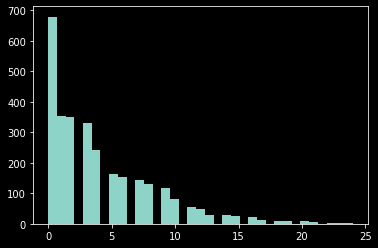

In [14]:
_ = plt.hist(labels_ints, bins='auto')
plt.show()

In [15]:
print('Before:', Counter(labels_ints))
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(features, labels_ints)
print('After:', Counter(y_resampled))

Before: Counter({0: 679, 1: 353, 2: 349, 3: 329, 4: 242, 5: 164, 6: 154, 7: 144, 8: 129, 9: 119, 10: 81, 11: 56, 12: 48, 13: 28, 14: 28, 15: 26, 16: 23, 17: 12, 18: 10, 19: 9, 20: 8, 21: 6, 22: 4, 23: 2, 24: 1})
After: Counter({4: 679, 2: 679, 3: 679, 21: 679, 16: 679, 10: 679, 9: 679, 1: 679, 0: 679, 12: 679, 17: 679, 13: 679, 8: 679, 15: 679, 19: 679, 6: 679, 11: 679, 14: 679, 23: 679, 7: 679, 5: 679, 18: 679, 20: 679, 22: 679, 24: 679})


## Split and Scale

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.25, random_state = 21)

In [21]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Random Forest

In [27]:
rfc = RandomForestClassifier(n_estimators=20, max_depth=15, criterion='entropy', random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [28]:
y_pred = rfc.predict(X_test)
print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))

Predicted  0   1    2    3    4    5    6    7    8    9   ...   15   16   17  \
Actual                                                     ...                  
0          28   7   10   17   10   47    8    0   33    7  ...    3    1    0   
1          11  48    5    4    3    3    3   50    1    5  ...    2    0    0   
2           7   0  109    7    9    3    1    5    3    3  ...    1    0    0   
3           9   4    6  111    4    4    4    3    4    1  ...    2    0    7   
4           4   0    0    6  153    0    0    0    3    0  ...    0    3    0   
5          11   0    0    1    0  171    1    1    0    0  ...    0    0    0   
6           0   0    0    1    5    0  106    1    0    3  ...   24   10    2   
7           1  22    3    0    0    4    0  107    0    0  ...    1    0    0   
8           1   0    0    0    0    0    0    0  166    0  ...    2    0    0   
9           0   0    0    2    0    0    6    0    0  148  ...    0    0    0   
10          0   0    0    0 

In [29]:
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {:.4f}'.format(accuracy))

Misclassified samples: 793
Accuracy: 0.8131


# Logistic Regression

In [0]:
lr = LogisticRegression(solver='newton-cg', max_iter=500, C=1.8, random_state=42, multi_class='multinomial')
lr.fit(X_train, y_train)

LogisticRegression(C=1.8, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred = lr.predict(X_test)

In [0]:
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {:.4f}'.format(accuracy))

Misclassified samples: 1486
Accuracy: 0.6499


In [0]:
print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))

Predicted  0   1   2   3   4   5   6   ...   18   19   20   21   22   23   24
Actual                                 ...                                   
0           6   7  14   4   2  24  13  ...    1    1    1    1    0    0    0
1           7  15   6  12   6  12  10  ...    0    1    0    1    0    0    0
2           3   7  33   6   9  15   2  ...    2    0    0    2    0    0    0
3           8   9  15  28  12   6   9  ...    0    2    0    1    0    0    0
4           6   7  11   9  57   6  13  ...    0    0    0    0    0    0    0
5          12  12  11   2  10  81   9  ...    0    0    0    0    2    0    0
6           2   4   5   8   5  14  41  ...   12    2    0    2    0    0    0
7           8  14   4   6   2   8   8  ...    0    0    0    0    0    0    0
8           5   5   6   9   0   4   2  ...    0    0    0    0    0    0    0
9           1   4   5  13   4   7  14  ...    0    1    0    0    0    0    0
10          2   0   6   4   9   7   1  ...    0    0    0    0  

# MLPClassifier

In [0]:
mlpc = MLPClassifier(random_state=42, activation='logistic', solver='lbfgs',
                     max_iter=400, hidden_layer_sizes=(400, 200))
mlpc.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(400, 200), learning_rate='constant',
              learning_rate_init=0.001, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=42, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [0]:
y_pred = mlpc.predict(X_test)

In [0]:
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {:.4f}'.format(accuracy))

Misclassified samples: 809
Accuracy: 0.8094


# Preparation

In [16]:
split_frac = 0.8

labeled_data = np.array([(x, y) for x, y in zip(X_resampled, y_resampled)])
np.random.shuffle(labeled_data)
X_resampled = np.array([d[0] for d in labeled_data])
y_resampled = np.array([d[1] for d in labeled_data])


split_idx = int(len(X_resampled)*split_frac)
train_x, remaining_x = X_resampled[:split_idx], X_resampled[split_idx:]
train_y, remaining_y = y_resampled[:split_idx], y_resampled[split_idx:]

scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
remaining_x = scaler.transform(remaining_x)

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))
print("Train set: \t\t{}".format(train_y.shape), 
      "\nValidation set: \t{}".format(val_y.shape),
      "\nTest set: \t\t{}".format(test_y.shape))

Feature Shapes:
Train set: 		(13580, 200) 
Validation set: 	(1697, 200) 
Test set: 		(1698, 200)
Train set: 		(13580,) 
Validation set: 	(1697,) 
Test set: 		(1698,)


In [17]:
# for CNN only
train_x = train_x[:, :, newaxis]
val_x = val_x[:, :, newaxis]
test_x = test_x[:, :, newaxis]

In [18]:
# for CNN only
train_x = np.swapaxes(train_x, 1, 2)
val_x = np.swapaxes(val_x, 1, 2)
test_x = np.swapaxes(test_x, 1, 2)

In [39]:
# train_x = train_x / np.linalg.norm(train_x)
# val_x = val_x / np.linalg.norm(val_x)
# test_x = test_x / np.linalg.norm(test_x)

In [19]:
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

batch_size = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [20]:
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size())
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size())
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 1, 200])
Sample input: 
 tensor([[[-0.2464,  0.5314,  0.0584,  ...,  0.6415,  0.2199,  0.4241]],

        [[-0.3050, -0.3928, -0.2139,  ..., -0.3736,  1.7052,  1.9059]],

        [[-0.3050, -0.3928, -0.2139,  ..., -0.3742, -0.4779,  0.3125]],

        ...,

        [[-0.3050, -0.3928, -0.2139,  ..., -0.3736,  0.9748,  0.7858]],

        [[-0.3050, -0.3928, -0.2139,  ..., -0.4872, -0.5486,  0.0557]],

        [[-0.3050, -0.3928, -0.2139,  ..., -0.4538, -0.0997, -0.6430]]],
       dtype=torch.float64)

Sample label size:  torch.Size([50])
Sample label: 
 tensor([14, 12, 16, 16,  8,  3, 21,  8,  6,  9,  0,  6,  7,  2, 18, 20,  3,  9,
         2, 11, 16, 11, 14, 22,  8,  5,  5,  6,  8, 23,  7, 18, 23,  3,  1, 11,
         8,  9,  9, 10,  7, 19,  4, 11, 23, 19, 18, 12, 16, 10],
       dtype=torch.int32)


# CNN

In [21]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv1d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool1d(2, 2)
        self.fc1 = nn.Linear(64 * 25, 500)
        self.fc2 = nn.Linear(500, 25)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 25)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = Net()
print(model)

if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=25, bias=True)
  (dropout): Dropout(p=0.2)
)


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.02)

In [23]:
n_epochs = 50

valid_loss_min = np.Inf

model.double()

for epoch in range(1, n_epochs + 1):

    train_loss = 0.0
    valid_loss = 0.0

    model.train()
    for data, target in train_loader:
        if target.shape != torch.Size([50]):
          break
        
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    model.eval()
    for data, target in valid_loader:

        if target.shape != torch.Size([50]):
          break

        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        output = model(data)
        loss = criterion(output, target.long())
        valid_loss += loss.item()*data.size(0)

    
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cnn1.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 3.185006 	Validation Loss: 3.032702
Validation loss decreased (inf --> 3.032702).  Saving model ...
Epoch: 2 	Training Loss: 2.781082 	Validation Loss: 2.314190
Validation loss decreased (3.032702 --> 2.314190).  Saving model ...
Epoch: 3 	Training Loss: 2.215234 	Validation Loss: 1.850910
Validation loss decreased (2.314190 --> 1.850910).  Saving model ...
Epoch: 4 	Training Loss: 1.788538 	Validation Loss: 1.566944
Validation loss decreased (1.850910 --> 1.566944).  Saving model ...
Epoch: 5 	Training Loss: 1.503558 	Validation Loss: 1.318645
Validation loss decreased (1.566944 --> 1.318645).  Saving model ...
Epoch: 6 	Training Loss: 1.310107 	Validation Loss: 1.161273
Validation loss decreased (1.318645 --> 1.161273).  Saving model ...


KeyboardInterrupt: 

In [76]:
test_loss = 0.0
class_correct = list(0. for i in range(25))
class_total = list(0. for i in range(25))
classes = label_vocab[:]

model.eval()

for data, target in test_loader:
    if target.shape != torch.Size([50]):
      break
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target.long())
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.long().data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(25):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.648292

Test Accuracy of JavaScript Developer
: 31% (25/79)
Test Accuracy of Java Developer
: 18% (11/61)
Test Accuracy of C#,.Net Developer
: 61% (48/78)
Test Accuracy of C,C++ Developer
: 74% (47/63)
Test Accuracy of Business Analyst
: 87% (51/58)
Test Accuracy of Senior JavaScript Developer
: 91% (68/74)
Test Accuracy of Python Developer
: 58% (27/46)
Test Accuracy of Senior Java Developer
: 69% (51/73)
Test Accuracy of Junior JavaScript Developer
: 85% (61/71)
Test Accuracy of DevOps Engineer
: 89% (59/66)
Test Accuracy of Database Developer
: 96% (64/66)
Test Accuracy of Ruby Developer
: 65% (47/72)
Test Accuracy of Junior C#,.Net Developer
: 90% (60/66)
Test Accuracy of Junior Java Developer
: 100% (54/54)
Test Accuracy of Scala Developer
: 65% (40/61)
Test Accuracy of Junior Python Developer
: 64% (37/57)
Test Accuracy of Data Scientist
: 95% (66/69)
Test Accuracy of Junior C,C++ Developer
: 75% (31/41)
Test Accuracy of Senior Python Developer
: 100% (66/66)
Test Ac

# RNN

In [81]:
class ClassificationRNN(nn.Module):

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
    
        super(ClassificationRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        self.dropout = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(25600, 2560)
        self.fc2 = nn.Linear(2560, 512)
        self.fc3 = nn.Linear(512, 25)       

    def forward(self, x, hidden):

        batch_size = x.size(0)

        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        lstm_out = lstm_out.contiguous()
        
        out = lstm_out.view(batch_size, -1)

        out = self.fc1(self.dropout(out))
        out = self.fc2(self.dropout(out))
        out = self.fc3(out)

        return out, hidden
    
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [82]:
vocab_size = len(vocab_to_int) + 1
output_size = 25
embedding_dim = 200
hidden_dim = 128
n_layers = 3

net = ClassificationRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

ClassificationRNN(
  (embedding): Embedding(14398, 200)
  (lstm): LSTM(200, 128, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3)
  (fc1): Linear(in_features=25600, out_features=2560, bias=True)
  (fc2): Linear(in_features=2560, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=25, bias=True)
)


In [83]:
lr=0.02

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [84]:
epochs = 4

counter = 0
print_every = 10
clip= 5
valid_loss_min = np.Inf

if(train_on_gpu):
    net.cuda()

net.train()
for e in range(epochs):
    h = net.init_hidden(batch_size)

    for inputs, labels in train_loader:
        if labels.shape != torch.Size([50]):
            break
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        h = tuple([each.data for each in h])

        net.zero_grad()

        output, h = net(inputs, h)

        loss = criterion(output, labels.long())
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        if counter % print_every == 0:
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:
                if labels.shape != torch.Size([50]):
                    break

                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output, labels.long())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if val_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                val_loss))
                torch.save(net.state_dict(), 'model_rnn1.pt')
                valid_loss_min = val_loss

Epoch: 1/4... Step: 10... Loss: 6393.428711... Val Loss: 14833.123609
Validation loss decreased (inf --> 14261.666016).  Saving model ...
Epoch: 1/4... Step: 20... Loss: 6297.510742... Val Loss: 7535.593706
Validation loss decreased (14261.666016 --> 7404.977051).  Saving model ...
Epoch: 1/4... Step: 30... Loss: 2199.794678... Val Loss: 1667.383745
Validation loss decreased (7404.977051 --> 1768.770020).  Saving model ...
Epoch: 1/4... Step: 40... Loss: 712.694153... Val Loss: 554.111938
Validation loss decreased (1768.770020 --> 499.142670).  Saving model ...
Epoch: 1/4... Step: 50... Loss: 115.422287... Val Loss: 62.986034
Validation loss decreased (499.142670 --> 69.567642).  Saving model ...
Epoch: 1/4... Step: 60... Loss: 15.505131... Val Loss: 26.124357
Validation loss decreased (69.567642 --> 24.121637).  Saving model ...
Epoch: 1/4... Step: 70... Loss: 15.066048... Val Loss: 19.512581
Validation loss decreased (24.121637 --> 18.971783).  Saving model ...
Epoch: 1/4... Step: 80

KeyboardInterrupt: 

In [74]:
h = net.init_hidden(batch_size)

test_loss = 0.0
class_correct = list(0. for i in range(25))
class_total = list(0. for i in range(25))

classes = label_vocab[:]

net.eval()

for data, target in test_loader:

    if target.shape != torch.Size([50]):
        break
    h = tuple([each.data for each in h])
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output, h = net(inputs, h)

    loss = criterion(output, target.long())
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.long().data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1


test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(25):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 7.699228

Test Accuracy of JavaScript Developer
:  1% ( 1/67)
Test Accuracy of Java Developer
:  0% ( 0/59)
Test Accuracy of C#,.Net Developer
:  0% ( 0/66)
Test Accuracy of C,C++ Developer
:  0% ( 0/64)
Test Accuracy of Business Analyst
:  4% ( 3/67)
Test Accuracy of Senior JavaScript Developer
:  2% ( 2/77)
Test Accuracy of Python Developer
:  5% ( 4/76)
Test Accuracy of Senior Java Developer
:  0% ( 0/69)
Test Accuracy of Junior JavaScript Developer
:  3% ( 2/66)
Test Accuracy of DevOps Engineer
: 10% ( 7/69)
Test Accuracy of Database Developer
:  2% ( 2/69)
Test Accuracy of Ruby Developer
:  0% ( 0/64)
Test Accuracy of Junior C#,.Net Developer
:  3% ( 2/61)
Test Accuracy of Junior Java Developer
:  1% ( 1/53)
Test Accuracy of Scala Developer
: 11% ( 7/62)
Test Accuracy of Junior Python Developer
:  5% ( 4/71)
Test Accuracy of Data Scientist
:  4% ( 3/64)
Test Accuracy of Junior C,C++ Developer
:  0% ( 0/53)
Test Accuracy of Senior Python Developer
:  3% ( 2/61)
Test Accu